# Posterior inference on a simple birth-death model

In [1]:
from gcdyn import models, mutators, poisson, utils
from scipy.stats import gamma, lognorm, norm
from functools import partial
import numpy as np
import seaborn as sns
from mcmc import mh_tour
from jax import jit
from jax.config import config
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

In [2]:
seed = 10

# (Deliberately avoiding rate parameters == constant 1, because a lot of bugs hide in this scenario)
true_parameters = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 2.0, 0.5),
    "death_response": poisson.ConstantResponse(1.3),
    "mutation_response": poisson.ConstantResponse(1.2),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5, 7, 9),
        transition_matrix=np.array(
            [
                [3, 2, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [1, 2, 3, 2, 1],
                [1, 1, 2, 3, 2],
                [1, 1, 2, 2, 3],
            ]
        )
        / 9,
    ),
    "extant_sampling_probability": 1,
}

PRESENT_TIME = 5

trees = utils.sample_trees(n=1, t=PRESENT_TIME, init_x=1, **true_parameters, seed=seed)

for tree in trees:
    tree._pruned = True
# to let σ=1

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 1 times.
Success: average of 264.0 nodes per tree, over 1 trees.


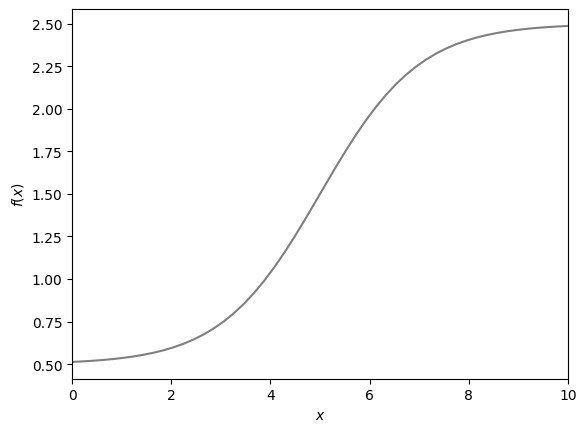

In [3]:
utils.plot_responses(true_parameters["birth_response"], x_range=(0, 10))

In [4]:
BIRTH_POSITIVE_PARAM_PRIOR = gamma(a=2, scale=1 / 3)
BIRTH_REAL_PARAM_PRIOR = norm(loc=0, scale=3)
DEATH_RESPONSE_PRIOR = gamma(a=3.5, scale=1 / 3)

BIRTH_POSITIVE_PARAM_PROPOSAL = lambda current: lognorm(scale=current, s=0.5)
BIRTH_REAL_PARAM_PROPOSAL = lambda current: norm(loc=current, scale=1)
DEATH_RESPONSE_PROPOSAL = lambda current: lognorm(scale=current.value, s=0.5)

log_priors = {
    "xscale": lambda θ: BIRTH_POSITIVE_PARAM_PRIOR.logpdf(θ),
    "xshift": lambda θ: BIRTH_REAL_PARAM_PRIOR.logpdf(θ),
    "yscale": lambda θ: BIRTH_POSITIVE_PARAM_PRIOR.logpdf(θ),
    "yshift": lambda θ: BIRTH_POSITIVE_PARAM_PRIOR.logpdf(θ),
    "death_response": lambda response: DEATH_RESPONSE_PRIOR.logpdf(response.value),
}

proposal_generators = {
    "xscale": lambda current: BIRTH_POSITIVE_PARAM_PROPOSAL(current).rvs(size=1).item(),
    "xshift": lambda current: BIRTH_REAL_PARAM_PROPOSAL(current).rvs(size=1).item(),
    "yscale": lambda current: BIRTH_POSITIVE_PARAM_PROPOSAL(current).rvs(size=1).item(),
    "yshift": lambda current: BIRTH_POSITIVE_PARAM_PROPOSAL(current).rvs(size=1).item(),
    "death_response": lambda current: poisson.ConstantResponse(
        DEATH_RESPONSE_PROPOSAL(current).rvs(size=1).item()
    ),
}

proposal_log_densities = {
    "xscale": lambda prop, cur: BIRTH_POSITIVE_PARAM_PROPOSAL(cur).logpdf(prop),
    "xshift": lambda prop, cur: BIRTH_REAL_PARAM_PROPOSAL(cur).logpdf(prop),
    "yscale": lambda prop, cur: BIRTH_POSITIVE_PARAM_PROPOSAL(cur).logpdf(prop),
    "yshift": lambda prop, cur: BIRTH_POSITIVE_PARAM_PROPOSAL(cur).logpdf(prop),
    "death_response": lambda prop, cur: DEATH_RESPONSE_PROPOSAL(cur).logpdf(prop.value),
}

log_likelihood_base = jit(
    partial(
        models.stadler_appx_log_likelihood,
        trees=trees,
        mutation_response=true_parameters["mutation_response"],
        mutator=true_parameters["mutator"],
        extant_sampling_probability=true_parameters["extant_sampling_probability"],
        extinct_sampling_probability=1,
        present_time=PRESENT_TIME,
    )
)


def log_likelihood(death_response, **birth_params):
    birth_response = poisson.SigmoidResponse(**birth_params)

    return log_likelihood_base(
        birth_response=birth_response,
        death_response=death_response,
    )

In [5]:
samples = mh_tour(
    num_samples=5000,
    initial_value={
        "xscale": true_parameters["birth_response"].xscale,
        "xshift": true_parameters["birth_response"].xshift,
        "yscale": true_parameters["birth_response"].yscale,
        "yshift": true_parameters["birth_response"].yshift,
        "death_response": poisson.ConstantResponse(2),
    },
    log_priors=log_priors,
    log_likelihood=log_likelihood,
    proposal_generators=proposal_generators,
    proposal_log_densities=proposal_log_densities,
)

  0%|          | 0/5000 [00:00<?, ?it/s]

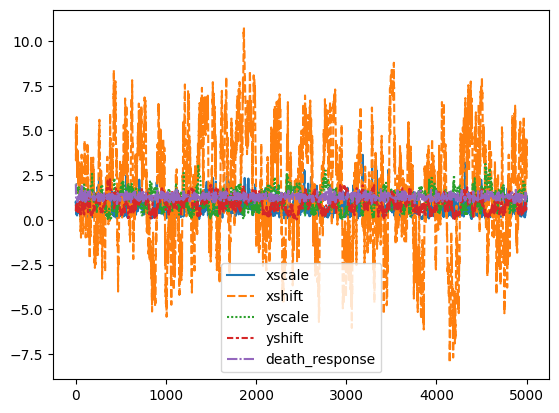

In [6]:
samples["death_response"] = np.array(
    [response.value for response in samples["death_response"]]
)

sns.lineplot(samples)
plt.show()

In [7]:
for param, chain in samples.items():
    acceptance_ratio = np.mean(chain[:-1] != chain[1:])
    print(f"Accepted {acceptance_ratio*100}% of {param} proposals")

Accepted 74.24% of xscale proposals
Accepted 85.1% of xshift proposals
Accepted 43.62% of yscale proposals
Accepted 44.0% of yshift proposals
Accepted 26.919999999999998% of death_response proposals


In [8]:
birth_samples = []

for i in range(len(samples["xscale"])):
    response = poisson.SigmoidResponse(
        xscale=samples["xscale"][i].item(),
        xshift=samples["xshift"][i].item(),
        yscale=samples["yscale"][i].item(),
        yshift=samples["yshift"][i].item(),
    )

    birth_samples.append(response)

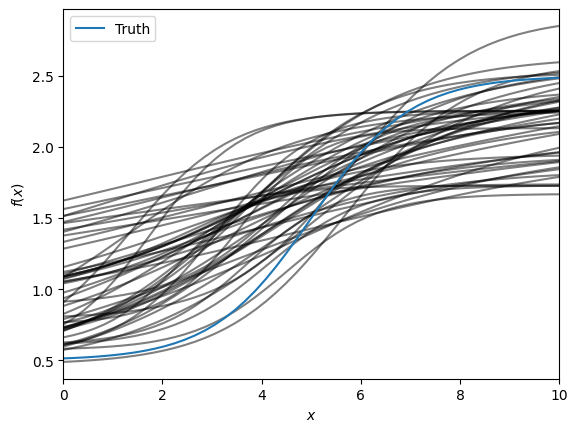

In [9]:
utils.plot_responses(
    *birth_samples[-50:],
    Truth=true_parameters["birth_response"],
    x_range=(0, 10),
)